In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import harmonypy
import pymn
import scrublet as scr
import gseapy as gp
from gseapy.plot import barplot, dotplot
import bottleneck
import pyreadr
from scipy.io import mmread
import scipy
from sklearn import preprocessing
import random as rd
import scib
from matplotlib_venn import venn2,venn2_circles,venn3
from pyscenic.export import export2loom, add_scenic_metadata
from sklearn.decomposition import NMF
from sklearn import metrics
import palettable
from pyscenic.rss import regulon_specificity_scores
import matplotlib.image as mpimg
import cosg as cosg
from pySankey.sankey import sankey

import matplotlib as mpl

from pyscenic.utils import modules_from_adjacencies
from IPython.display import display, Image


In [4]:
sc.set_figure_params(dpi = 200, color_map = 'viridis_r' )
sc.settings.verbosity = 2

# Ciliated Marker: Lung High vs Low

In [255]:
adata_high = sc.read('ciliated_cnv_obs_high.h5ad')
adata_high = adata_high[adata_high.obs['cancer_type'] == 'LUAD']

adata_low = sc.read('ciliated_cnv_obs_low.h5ad')

adata_all = sc.AnnData.concatenate(adata_high, adata_low,
                                   join = "outer", fill_value = 0, index_unique = None)

adata_all.write('ciliated_lung_only_DEG.h5ad')
adata_all.obs[['study_id', 'cnv_cluster_type']].to_csv('ciliated_lung_only_DEG.csv')

/public/home/guogjgroup/ggj/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [13]:
p_val_cutoff = 0.05
avg_log2FC_cutoff = 0.5
pct_1_cutoff = 0.25
pct_difference_cutoff = 0.1

all_marker = pd.DataFrame()

marker_dict = {}

each_tissue_marker = pd.read_csv('ciliated_lung_only_high_conserved_marker.csv', index_col=0)

if 'minimump_p_val' in each_tissue_marker.columns.tolist():

    each_tissue_marker[each_tissue_marker['minimump_p_val'] < p_val_cutoff]

#    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_p_val_adj' in s]:

#        each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] < p_val_cutoff]

    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_avg_log2FC' in s]:

        each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] > avg_log2FC_cutoff]

    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_pct.1' in s]:

        each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] > pct_1_cutoff]

    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_pct.1' in s]:

        selected_cluster = '_'.join(each_column.split('_')[:-1])

        for each_gene in each_tissue_marker.index.tolist():

            if each_tissue_marker.loc[each_gene, selected_cluster + '_pct.1'] - each_tissue_marker.loc[each_gene, selected_cluster + '_pct.2'] < pct_difference_cutoff:

                each_tissue_marker = each_tissue_marker.drop(each_gene)        

each_tissue_marker['cluster'] = 'high'
all_marker = pd.concat([all_marker, each_tissue_marker], axis=0)
                
marker_dict['high'] = each_tissue_marker.index.tolist()


each_tissue_marker = pd.read_csv('ciliated_lung_only_low_conserved_marker.csv', index_col=0)

if 'minimump_p_val' in each_tissue_marker.columns.tolist():

    each_tissue_marker[each_tissue_marker['minimump_p_val'] < p_val_cutoff]

#    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_p_val_adj' in s]:

#        each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] < p_val_cutoff]

    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_avg_log2FC' in s]:

        each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] > avg_log2FC_cutoff]

    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_pct.1' in s]:

        each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] > pct_1_cutoff]

    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_pct.1' in s]:

        selected_cluster = '_'.join(each_column.split('_')[:-1])

        for each_gene in each_tissue_marker.index.tolist():

            if each_tissue_marker.loc[each_gene, selected_cluster + '_pct.1'] - each_tissue_marker.loc[each_gene, selected_cluster + '_pct.2'] < pct_difference_cutoff:

                each_tissue_marker = each_tissue_marker.drop(each_gene)

each_tissue_marker['cluster'] = 'low'
all_marker = pd.concat([all_marker, each_tissue_marker], axis=0)
                
marker_dict['low'] = each_tissue_marker.index.tolist()

all_marker.to_csv('ciliated_high_low_lung_conserved_marker_latest.csv')

normalizing counts per cell


/public/home/guogjgroup/ggj/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


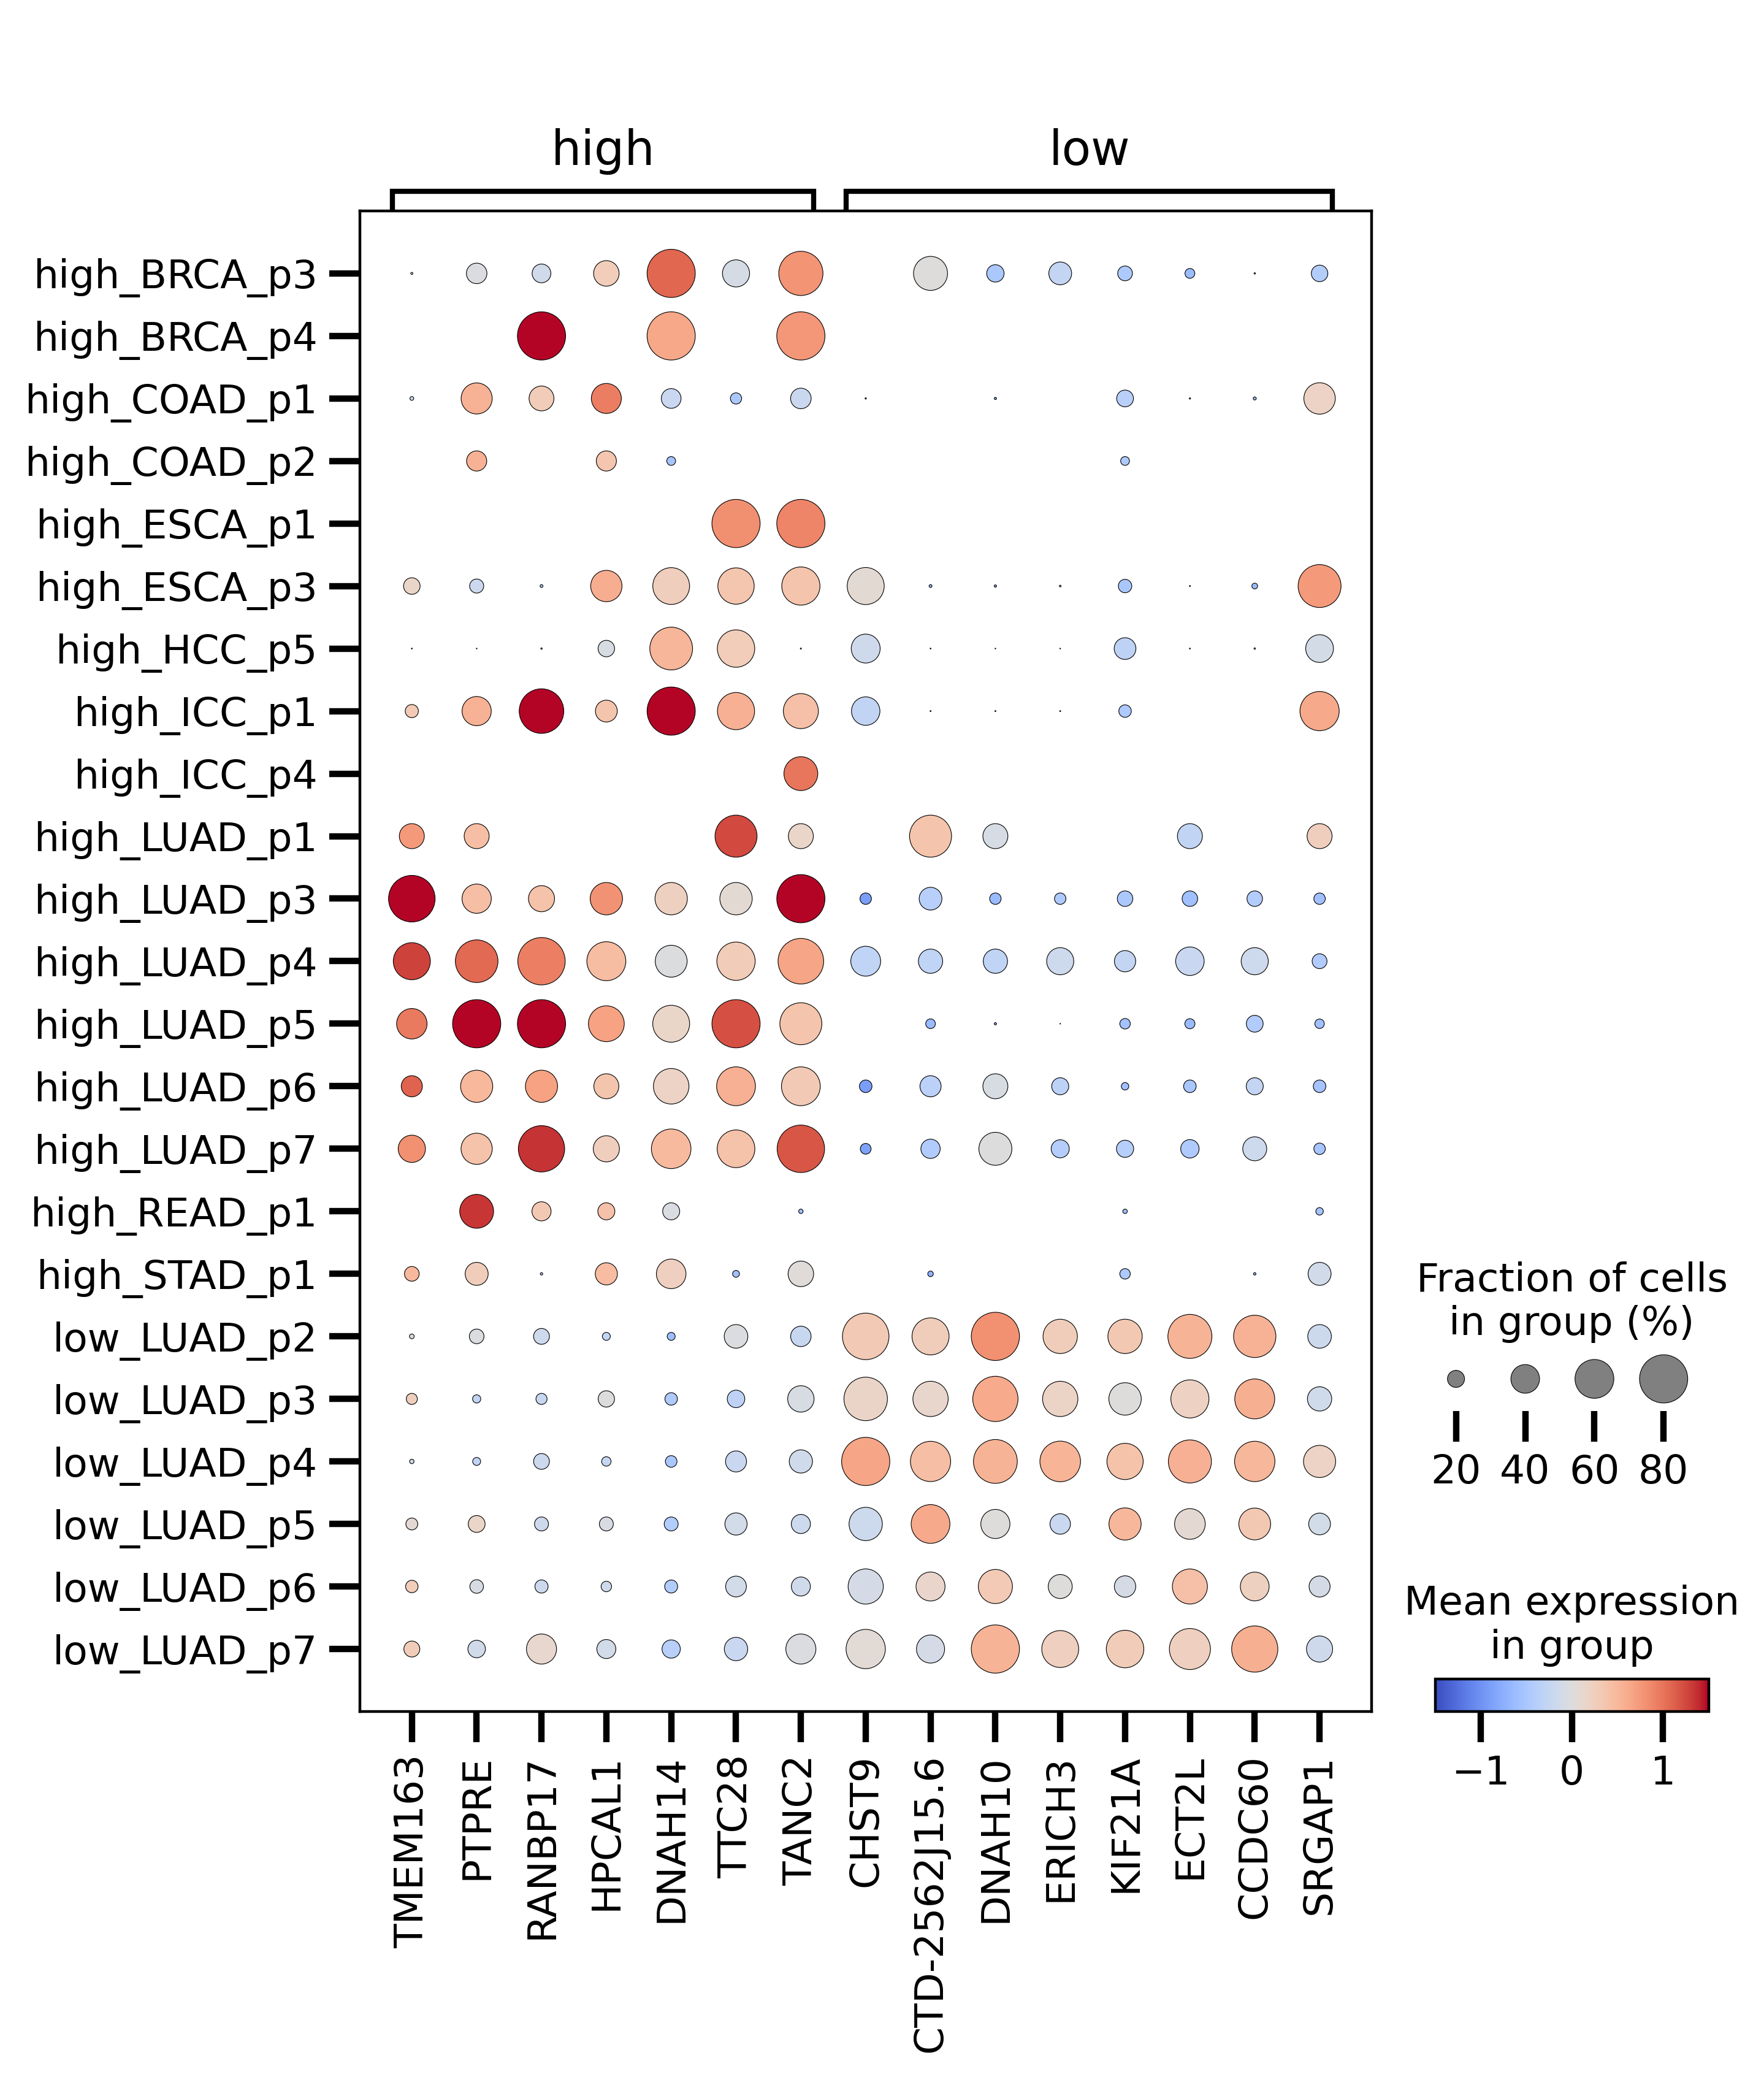

In [14]:
adata_high = sc.read('ciliated_cnv_obs_high.h5ad')

adata_low = sc.read('ciliated_cnv_obs_low.h5ad')

adata = sc.AnnData.concatenate(adata_high, adata_low,
                               join = "outer", fill_value = 0, index_unique = None)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

adata.obs['study_id'] = adata.obs['study_id'].astype(str)
adata.obs['cnv_cluster_type'] = adata.obs['cnv_cluster_type'].astype(str)
adata.obs['cnv_patient'] = adata.obs['cnv_cluster_type'] + '_' + adata.obs['study_id']

sc.pl.dotplot(adata, marker_dict, groupby='cnv_patient', use_raw=False, 
              vmin=-1.5, vmax=1.5, cmap='coolwarm', dot_max=0.8, save='DEG_between_malignant_normal_ciliated.pdf')

# low Ciliated Conserved Marker

In [20]:
p_val_cutoff = 0.05
avg_log2FC_cutoff = 0.5
pct_1_cutoff = 0.25
pct_difference_cutoff = 0.1

all_marker = pd.DataFrame()

marker_dict = {}

each_tissue_marker = pd.read_csv('lung_ciliated_low_conserved_marker.csv', index_col=0)

if 'minimump_p_val' in each_tissue_marker.columns.tolist():

    each_tissue_marker[each_tissue_marker['minimump_p_val'] < p_val_cutoff]

#    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_p_val_adj' in s]:

#        each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] < p_val_cutoff]

    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_avg_log2FC' in s]:

        each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] > avg_log2FC_cutoff]

    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_pct.1' in s]:

        each_tissue_marker = each_tissue_marker[each_tissue_marker[each_column] > pct_1_cutoff]

    for each_column in [s for s in each_tissue_marker.columns.tolist() if '_pct.1' in s]:

        selected_cluster = '_'.join(each_column.split('_')[:-1])

        for each_gene in each_tissue_marker.index.tolist():

            if each_tissue_marker.loc[each_gene, selected_cluster + '_pct.1'] - each_tissue_marker.loc[each_gene, selected_cluster + '_pct.2'] < pct_difference_cutoff:

                each_tissue_marker = each_tissue_marker.drop(each_gene)        

each_tissue_marker.to_csv('lung_ciliated_low_conserved_marker_filtered.csv')


In [17]:
adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/all_cell/adata_all_cell_raw_with_anno_latest.h5ad')
adata = adata[adata.obs['lineage'].isin(['Epithelium'])]
adata = adata[adata.obs['cancer_type'] == 'LUAD']

adata.obs['study_id'] = adata.obs['study_id'].astype(str)
adata.obs['Type'] = adata.obs['Type'].astype(str)
adata.obs['Type_patient'] = adata.obs['Type'] + '_' + adata.obs['study_id']

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.scale(adata)

/tmp/ipykernel_984/1572333600.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['study_id'] = adata.obs['study_id'].astype(str)


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:2503: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(mappable, cax=heatmap_cbar_ax)


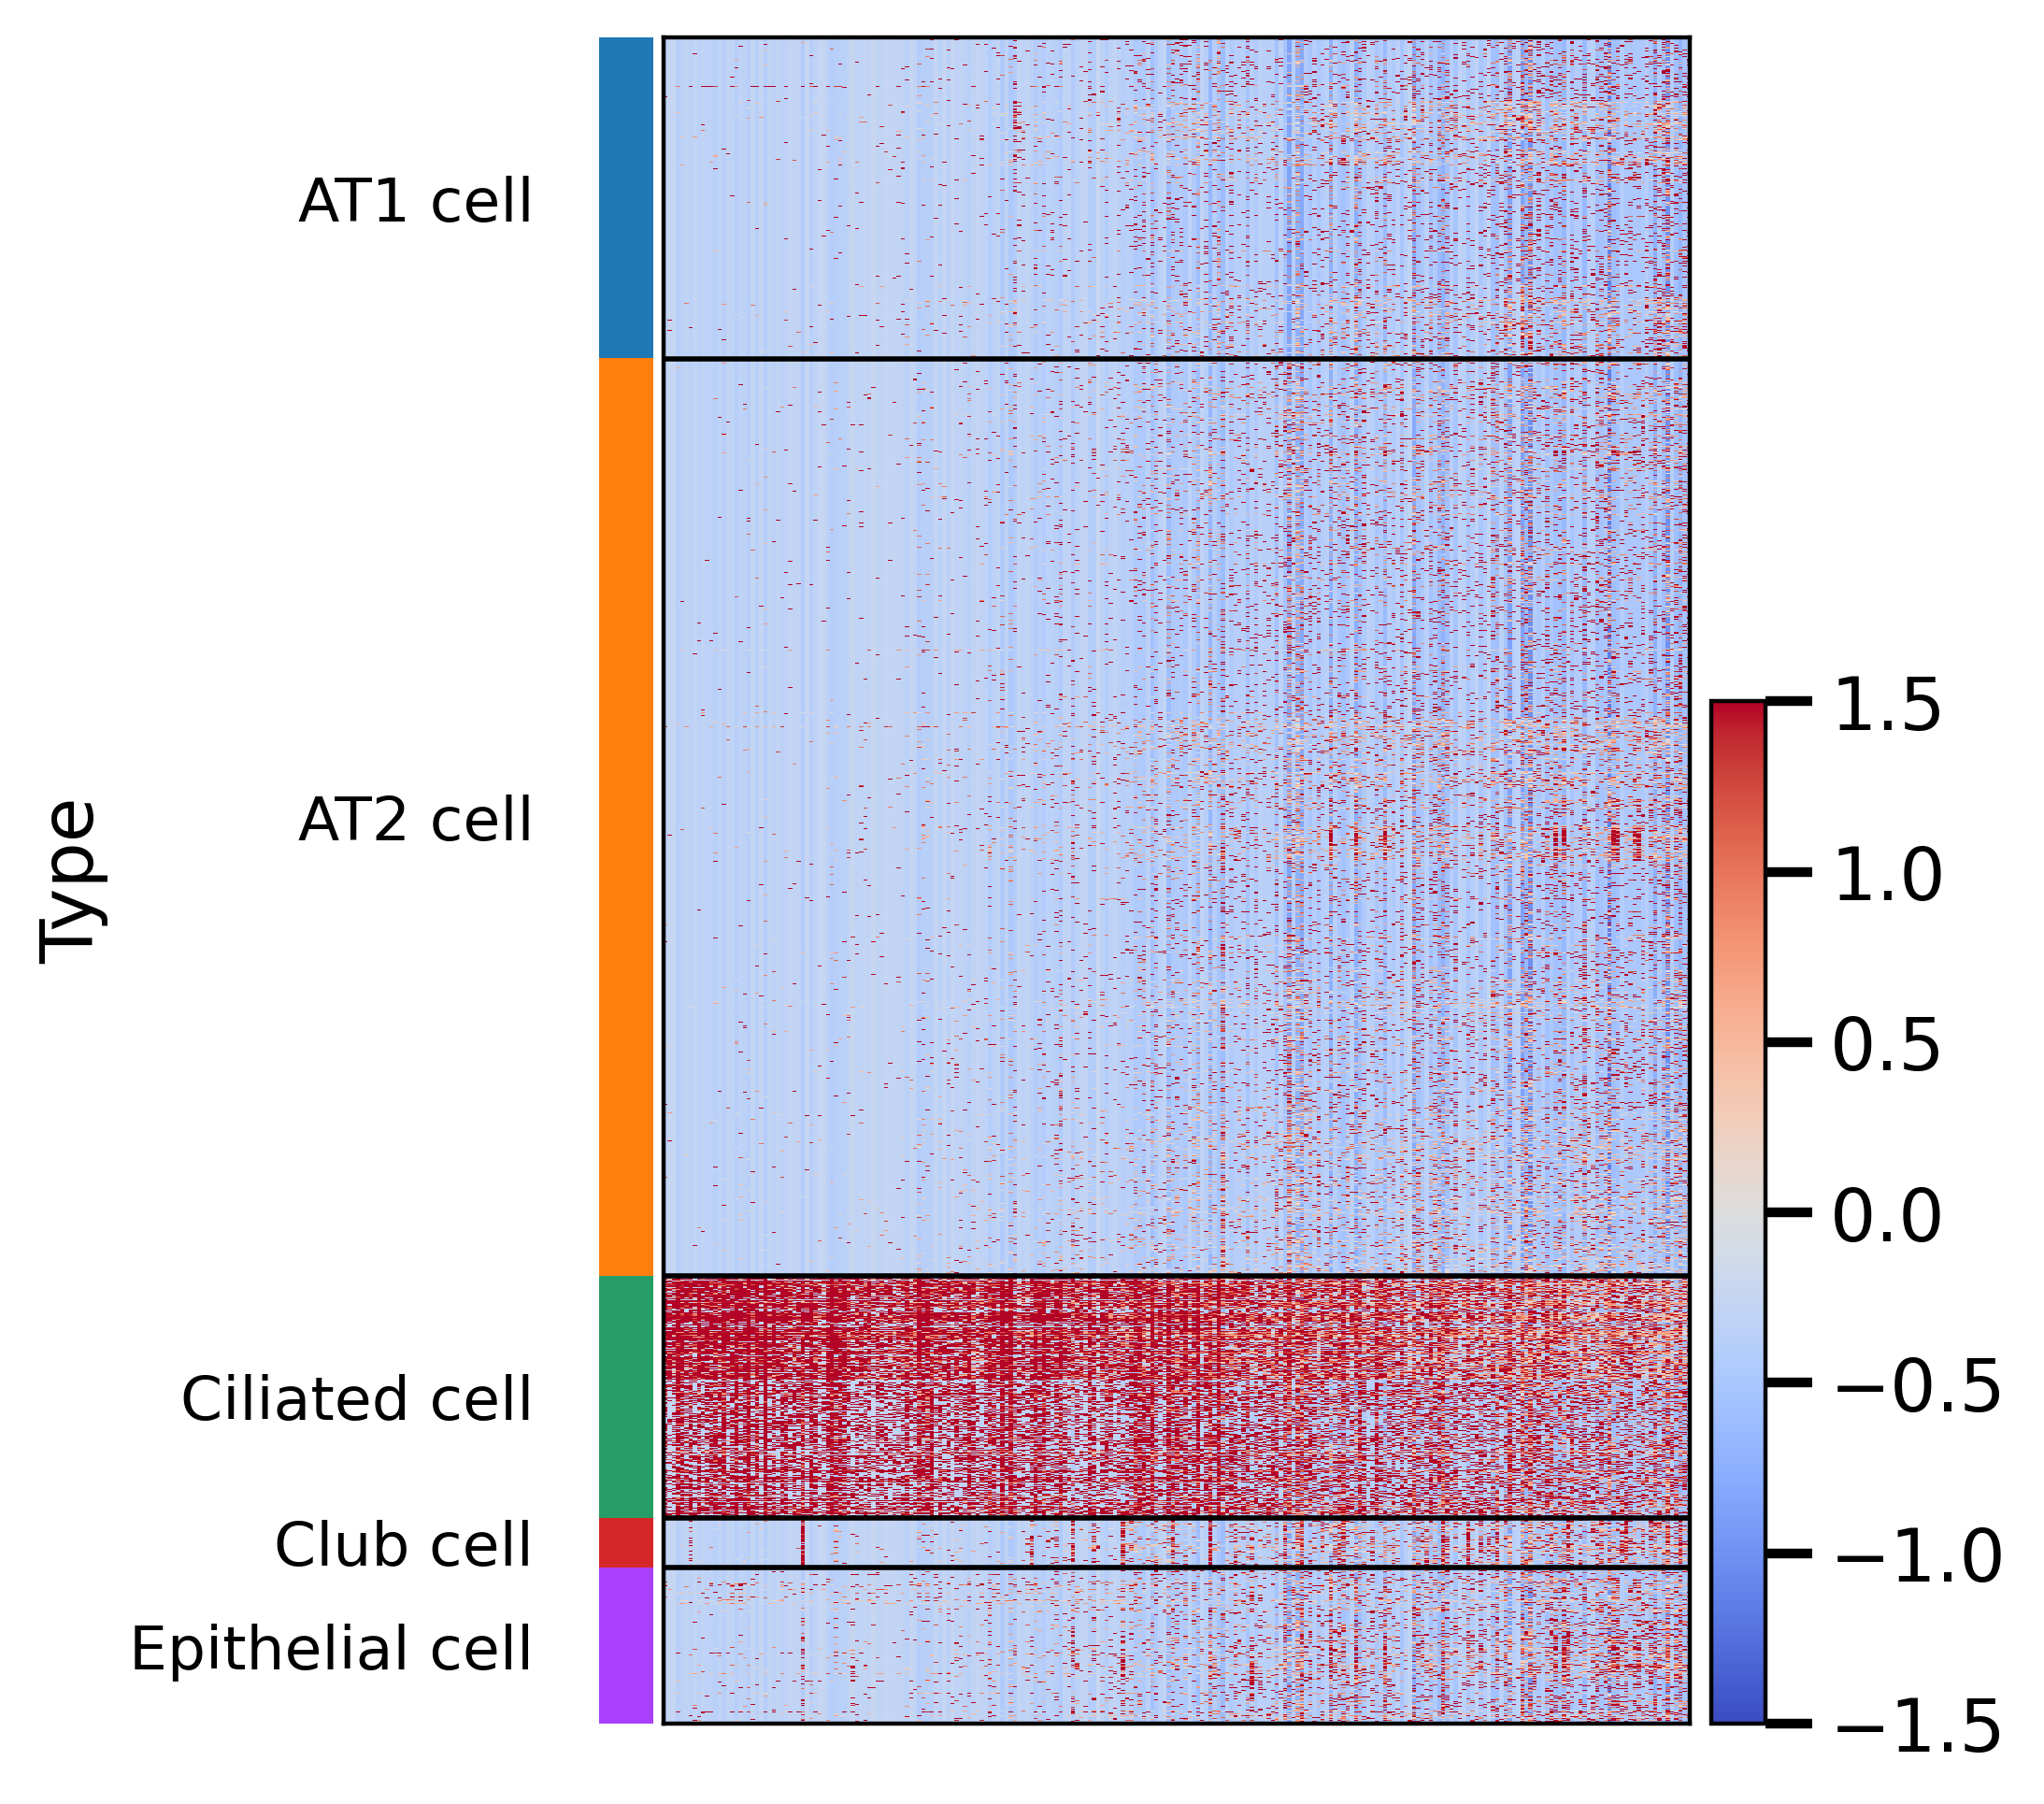

In [21]:
each_tissue_marker = pd.read_csv('lung_ciliated_low_conserved_marker_filtered.csv', index_col=0)

sc.pl.heatmap(adata, each_tissue_marker.index.tolist(), 
              groupby='Type', use_raw=False, figsize=[4, 6], 
              vmin=-1.5, vmax=1.5, cmap='coolwarm')

# C10: DEG (Each Cancer)

In [132]:
each_cancer_marker = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cnv_high_epi_harmony/cancer_subtype_marker_DEG/each_cancer_marker_latest.csv', index_col=0)
each_cancer_marker = each_cancer_marker[each_cancer_marker['cluster'] == 10]

In [84]:
each_cancer_marker['cancer_type'].value_counts()

BRCA         365
LUAD         227
ICC          102
ESCA          57
HCC           48
COAD_READ      5
STAD           5
Name: cancer_type, dtype: int64

In [85]:
with open('each_cancer_ciliated_GO.txt', 'w') as f:

    for each_cancer in np.unique(each_cancer_marker['cancer_type']).tolist():

        each_cancer_marker[each_cancer_marker['cancer_type'] == each_cancer]['gene'].tolist()

        f.write(str(each_cancer) + '\t')
        f.write(','.join(each_cancer_marker[each_cancer_marker['cancer_type'] == each_cancer]['gene'].tolist()))
        f.write('\n')

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


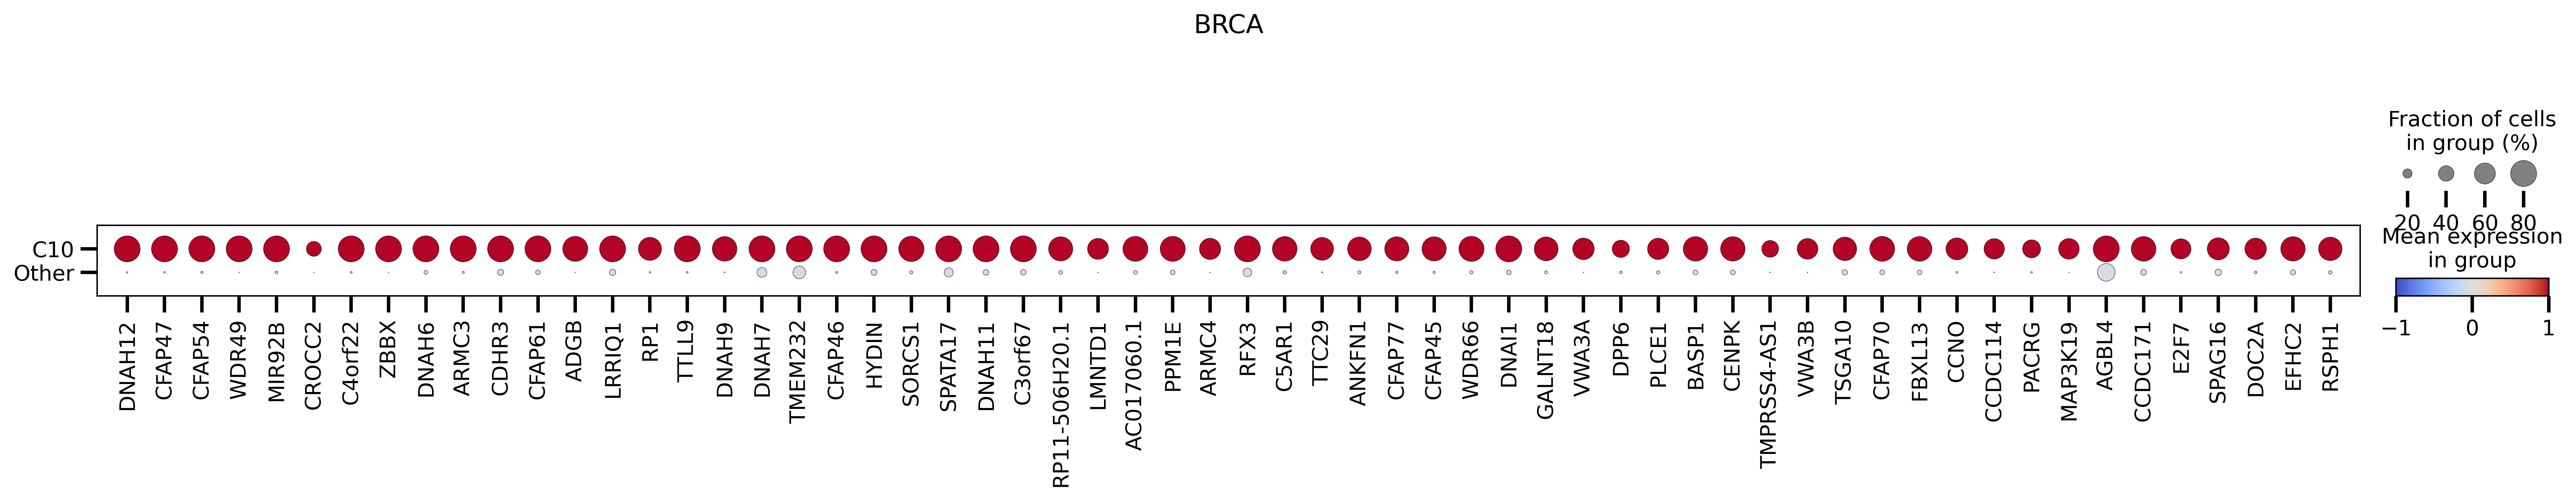

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


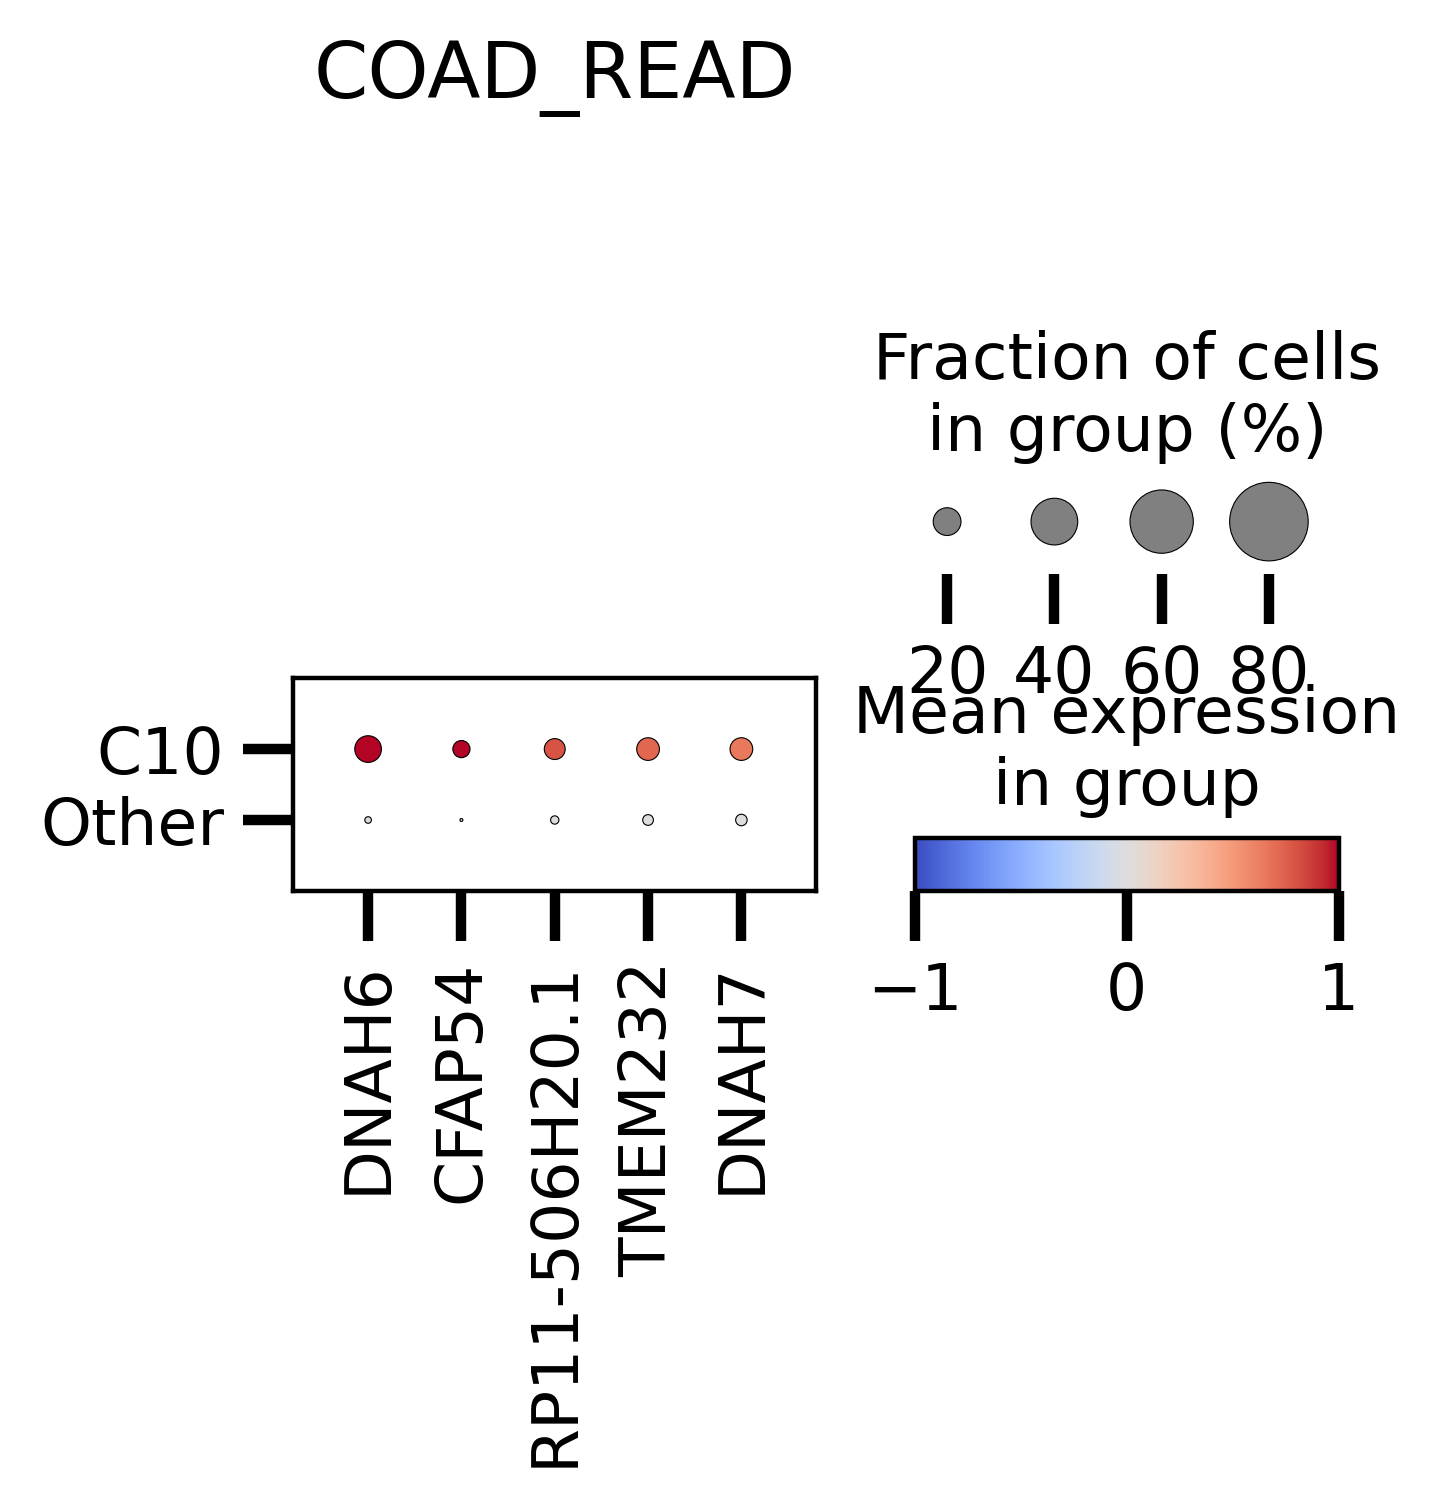

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


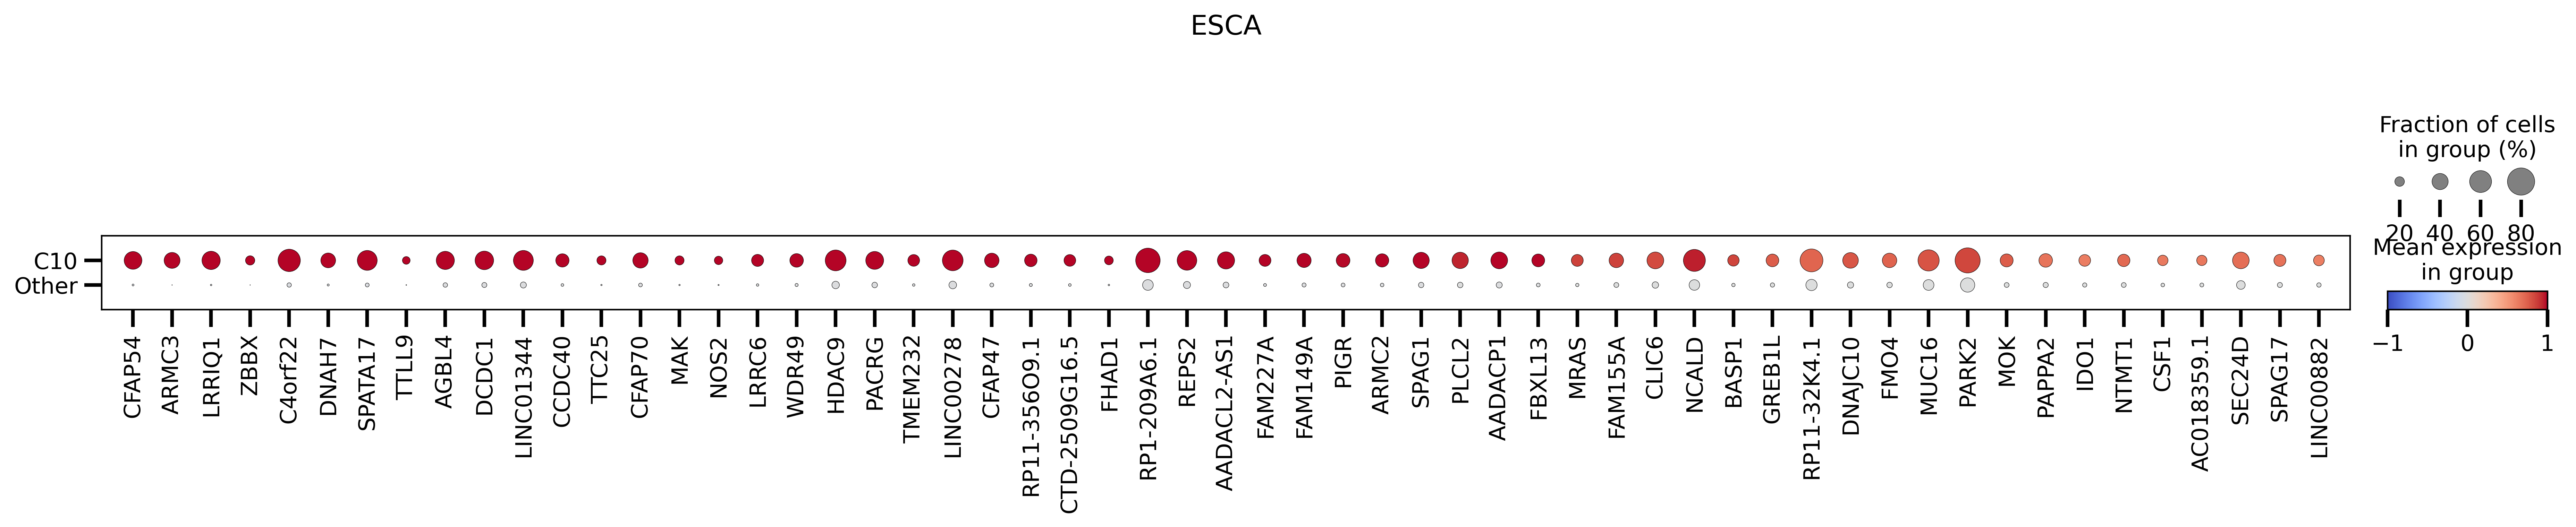

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


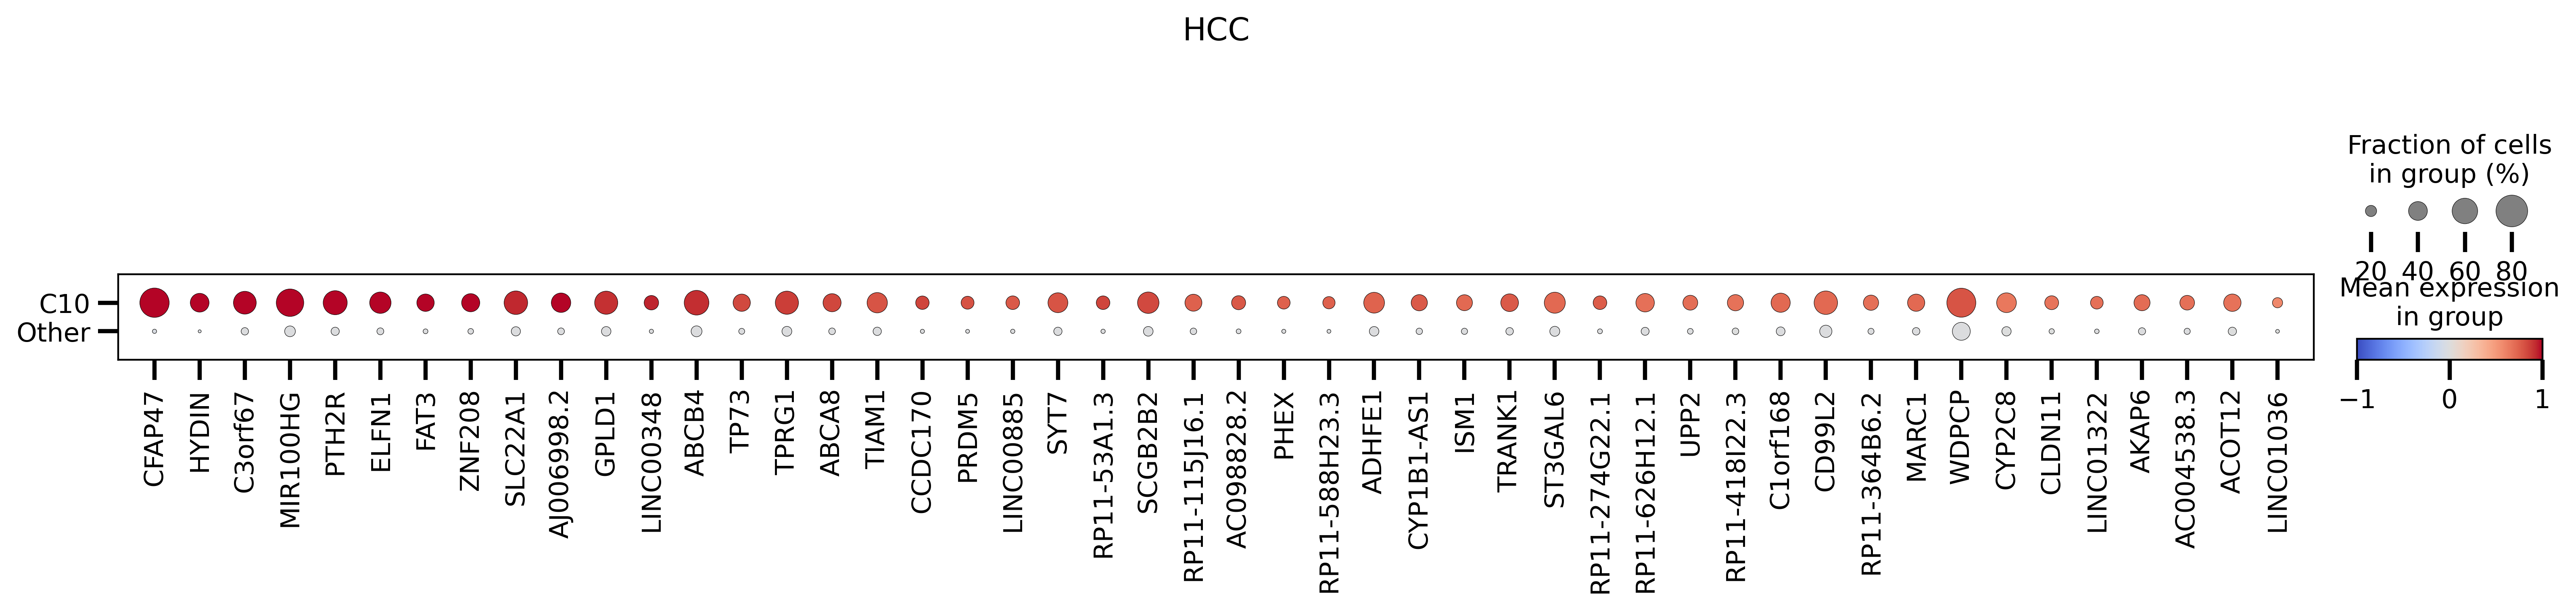

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


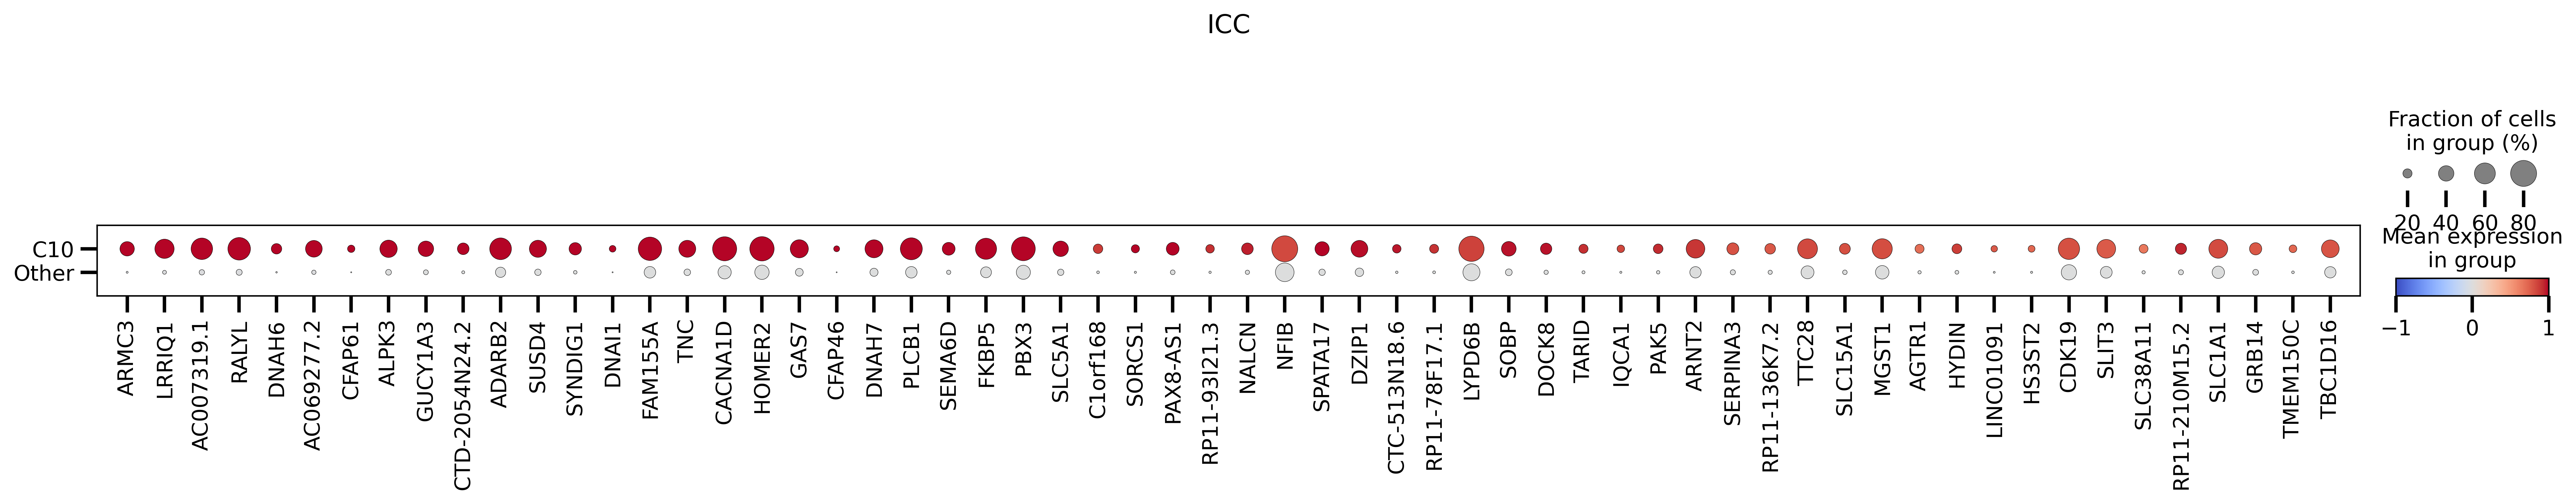

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


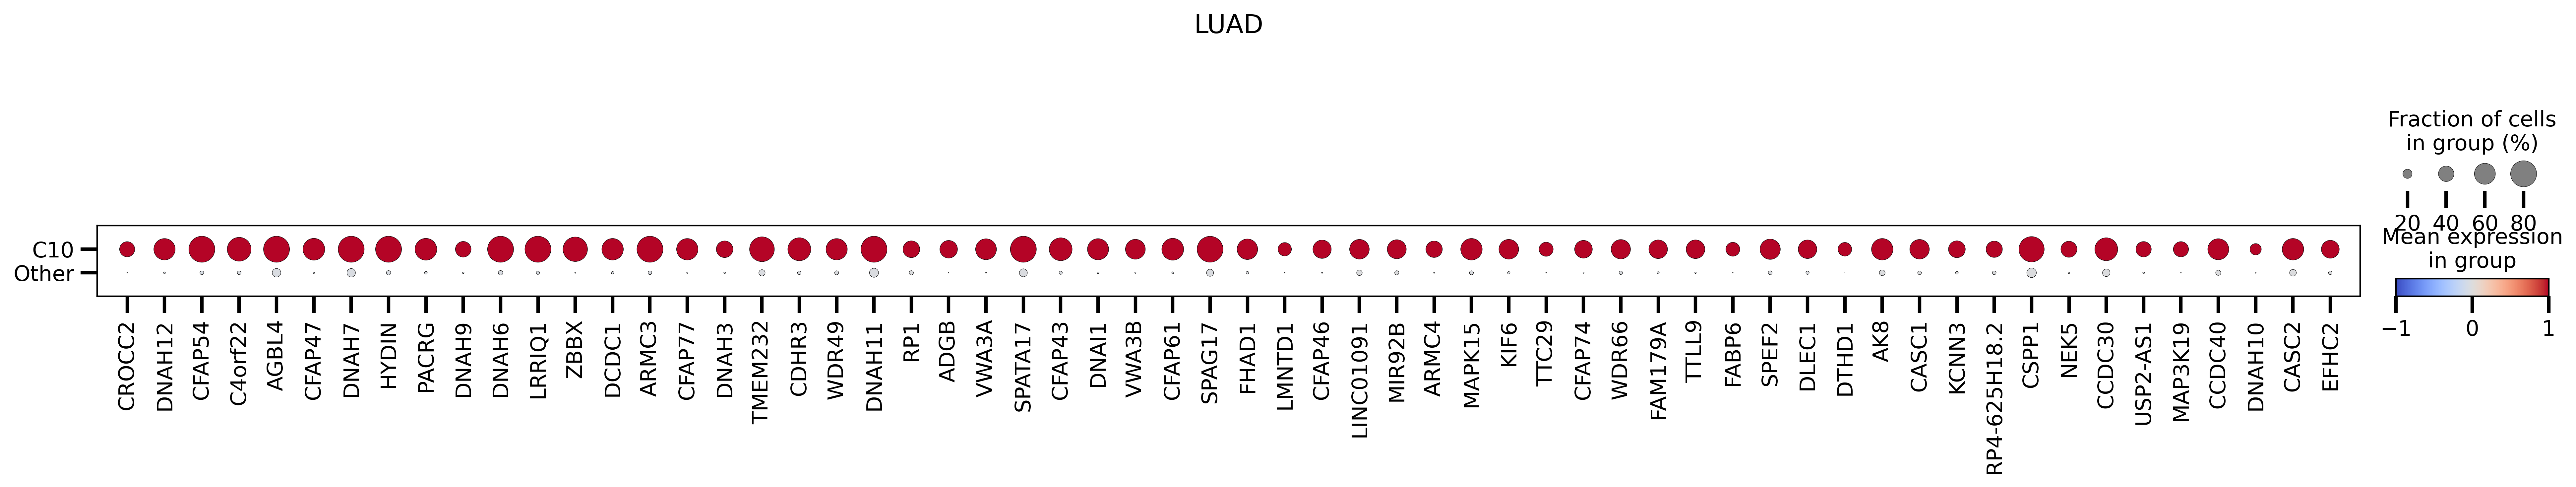

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


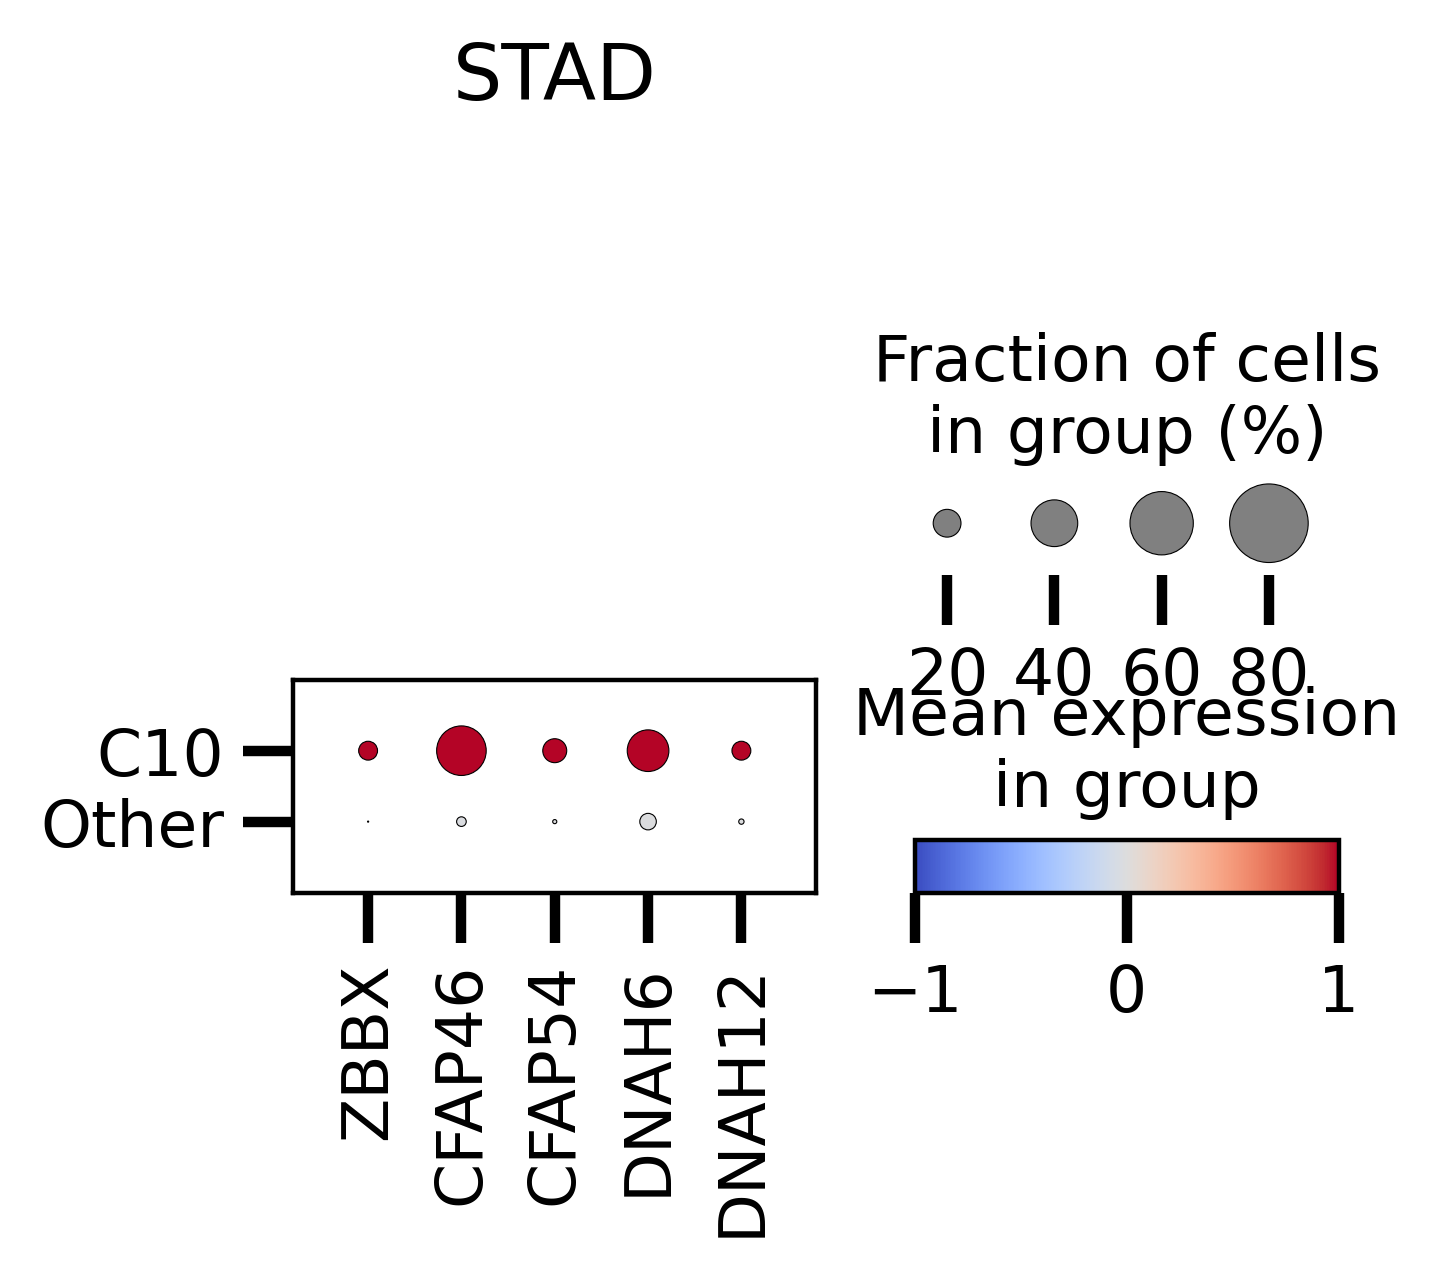

In [87]:
adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cnv_high_epi_harmony/cnv_high_epi_harmony_anno_latest.h5ad')

adata.obs['leiden'] = adata.obs['leiden'].astype(str)
adata.obs['study_id'] = adata.obs['study_id'].astype(str)
adata.obs['tissue'] = adata.obs['sample'].str.split('_', expand=True)[2]
adata.obs['tissue'] = adata.obs['tissue'].astype(str)

c10_YN = adata.obs[['leiden']].copy()
c10_YN['c10'] = 'C10'
c10_YN.loc[c10_YN[c10_YN['leiden'] != '10'].index.tolist(), 'c10'] = 'Other'

c10_YN = c10_YN.loc[adata.obs.index.tolist(), :]
adata.obs['c10'] = c10_YN['c10']

for each_cancer in np.unique(each_cancer_marker['cancer_type']).tolist():
    
    adata_subset = adata[adata.obs['cancer_type'] == each_cancer].copy()
    adata_subset = adata_subset[adata_subset.obs['leiden'] != '11']
    adata_subset = adata_subset[adata_subset.obs['leiden'] != '12']
    
    sc.pp.normalize_total(adata_subset)
    sc.pp.log1p(adata_subset)
    sc.pp.scale(adata_subset)
    
    sc.pl.dotplot(adata_subset,
                  each_cancer_marker[each_cancer_marker['cancer_type'] == each_cancer]['gene'][:60].tolist(), 
                  groupby='c10', use_raw=False, vmin=-1, vmax=1, cmap='coolwarm', title=each_cancer, dot_max=0.8,
                  save= each_cancer + '_c10_up.pdf')
    
#    sc.pl.dotplot(adata_subset,
#                  each_cancer_marker[each_cancer_marker['cancer_type'] == each_cancer]['gene'][-50:].tolist(), 
#                  groupby='c10', use_raw=False, vmin=-1, vmax=1, cmap='coolwarm', title=each_cancer, dot_max=0.8)
    

# Final: Marker Inter (High & Low Ciliated Cell)

In [150]:
adata_high = sc.read('ciliated_cnv_obs_high.h5ad')
adata_low = sc.read('ciliated_cnv_obs_low.h5ad')

adata = sc.AnnData.concatenate(adata_high, adata_low,
                               join = "outer", fill_value = 0, index_unique = None)

#adata.obs['study_id'] = adata.obs['study_id'].astype(str)
adata.obs['cancer_type'] = adata.obs['cancer_type'].astype(str)
adata.obs['cnv_cluster_type'] = adata.obs['cnv_cluster_type'].astype(str)
adata.obs['cnv_patient'] = adata.obs['cnv_cluster_type'] + '_' + adata.obs['cancer_type']
    
ciliated_patient = adata.obs[['cnv_patient']].copy()

del adata_high
del adata_low
del adata

adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cnv_high_DEG/cnv_high_differential_gene_expression_raw_all_gene.h5ad')
adata = adata[list(set(adata.obs.index.tolist()).difference(set(ciliated_patient.index.tolist()))), :]

other_patient = adata.obs[['cnv_cluster_type', 'cancer_type']].copy()
#other_patient.columns = ['cnv_patient']
#other_patient['cnv_patient'] = other_patient['cnv_patient'].astype(str)
#other_patient['cnv_patient'] = 'Ref_' + other_patient['cnv_patient']
other_patient['cnv_cluster_type'] = other_patient['cnv_cluster_type'].astype(str)
other_patient['cancer_type'] = other_patient['cancer_type'].astype(str)
other_patient['cnv_patient'] = 'Ref_' + other_patient['cnv_cluster_type'] + '_' + other_patient['cancer_type']
del other_patient['cnv_cluster_type']
del other_patient['cancer_type']

all_patient = pd.concat([ciliated_patient, other_patient], axis=0)

/public/home/guogjgroup/ggj/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [151]:
adata = sc.read('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cnv_high_DEG/cnv_high_differential_gene_expression_raw_all_gene.h5ad')

adata = adata[all_patient.index.tolist(), :]

adata.obs['cnv_patient'] = all_patient['cnv_patient'] 

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.scale(adata)


/tmp/ipykernel_27592/1518520011.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cnv_patient'] = all_patient['cnv_patient']


normalizing counts per cell
    finished (0:00:03)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [152]:
each_cancer_marker = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cnv_high_epi_harmony/cancer_subtype_marker_DEG/each_cancer_marker_latest.csv', index_col=0)
each_cancer_marker = each_cancer_marker[each_cancer_marker['cluster'] == 10]

inter = pd.DataFrame(each_cancer_marker['gene'].value_counts()).copy()
high_gene_list = inter[inter['gene'] >= 4].index.tolist()

pts_cutoff = 0.25
p_cutoff = 0.01
logFC_cutoff = 1
#logFC_cutoff = 0.5
pts_change_cutoff = 0.1
#pts_change_cutoff = 0

each_seurat = pd.read_csv('/public/home/guogjgroup/ggj/matq_analysis/pan_cancer/cancer_module/cnv_high_epi_harmony/cancer_subtype_marker_DEG/cancer_subtype_marker.csv', index_col=0)

each_seurat = each_seurat[each_seurat['pct.1'] > pts_cutoff]
each_seurat = each_seurat[each_seurat['p_val_adj'] < p_cutoff]
each_seurat = each_seurat[each_seurat['avg_log2FC'] > logFC_cutoff]

each_seurat['pts_change'] = each_seurat['pct.1'] - each_seurat['pct.2']
each_seurat = each_seurat[each_seurat['pts_change'] > pts_change_cutoff]

high_gene_list = list(set(each_seurat[each_seurat['cluster'] == 10]['gene'].tolist()).intersection(set(high_gene_list)))

low_gene_list = pd.read_csv('lung_ciliated_low_conserved_marker_filtered.csv', index_col=0).index.tolist()

list(set(high_gene_list).intersection(set(low_gene_list)))

['ZBBX',
 'TMEM232',
 'SPAG17',
 'LINC00882',
 'DNAH6',
 'CFAP46',
 'HYDIN',
 'DCDC1',
 'ARMC3',
 'CFAP47',
 'CFAP54',
 'ARMC2',
 'LRRIQ1',
 'SPATA17',
 'CCDC40',
 'DNAH7']

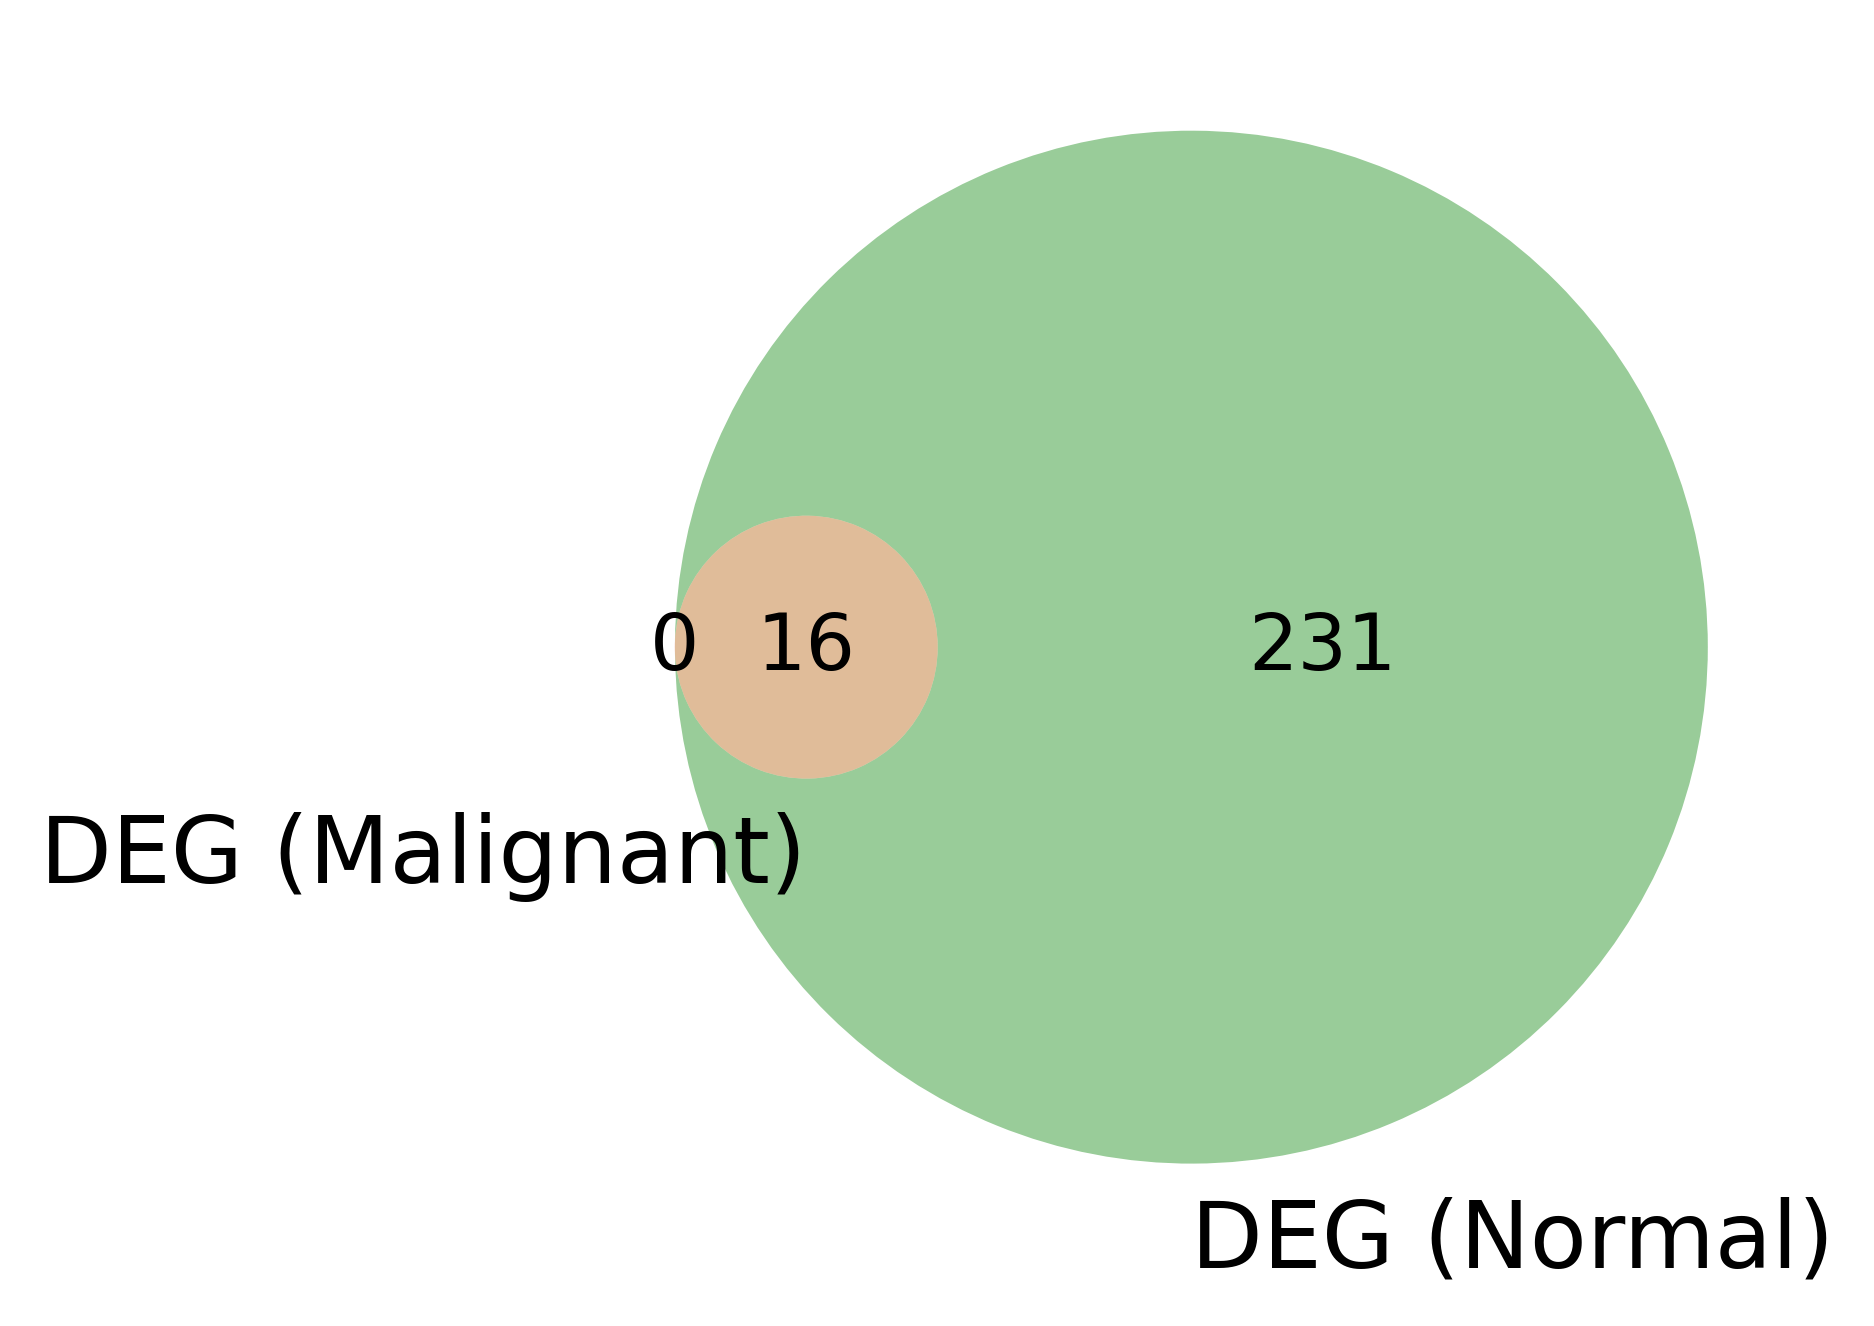

In [96]:
venn2(subsets=[set(high_gene_list), 
               set(low_gene_list)], 
               set_labels=('DEG (Malignant)', 'DEG (Normal)'))
plt.savefig('figures/DEG_inter.pdf')

/public/home/guogjgroup/ggj/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


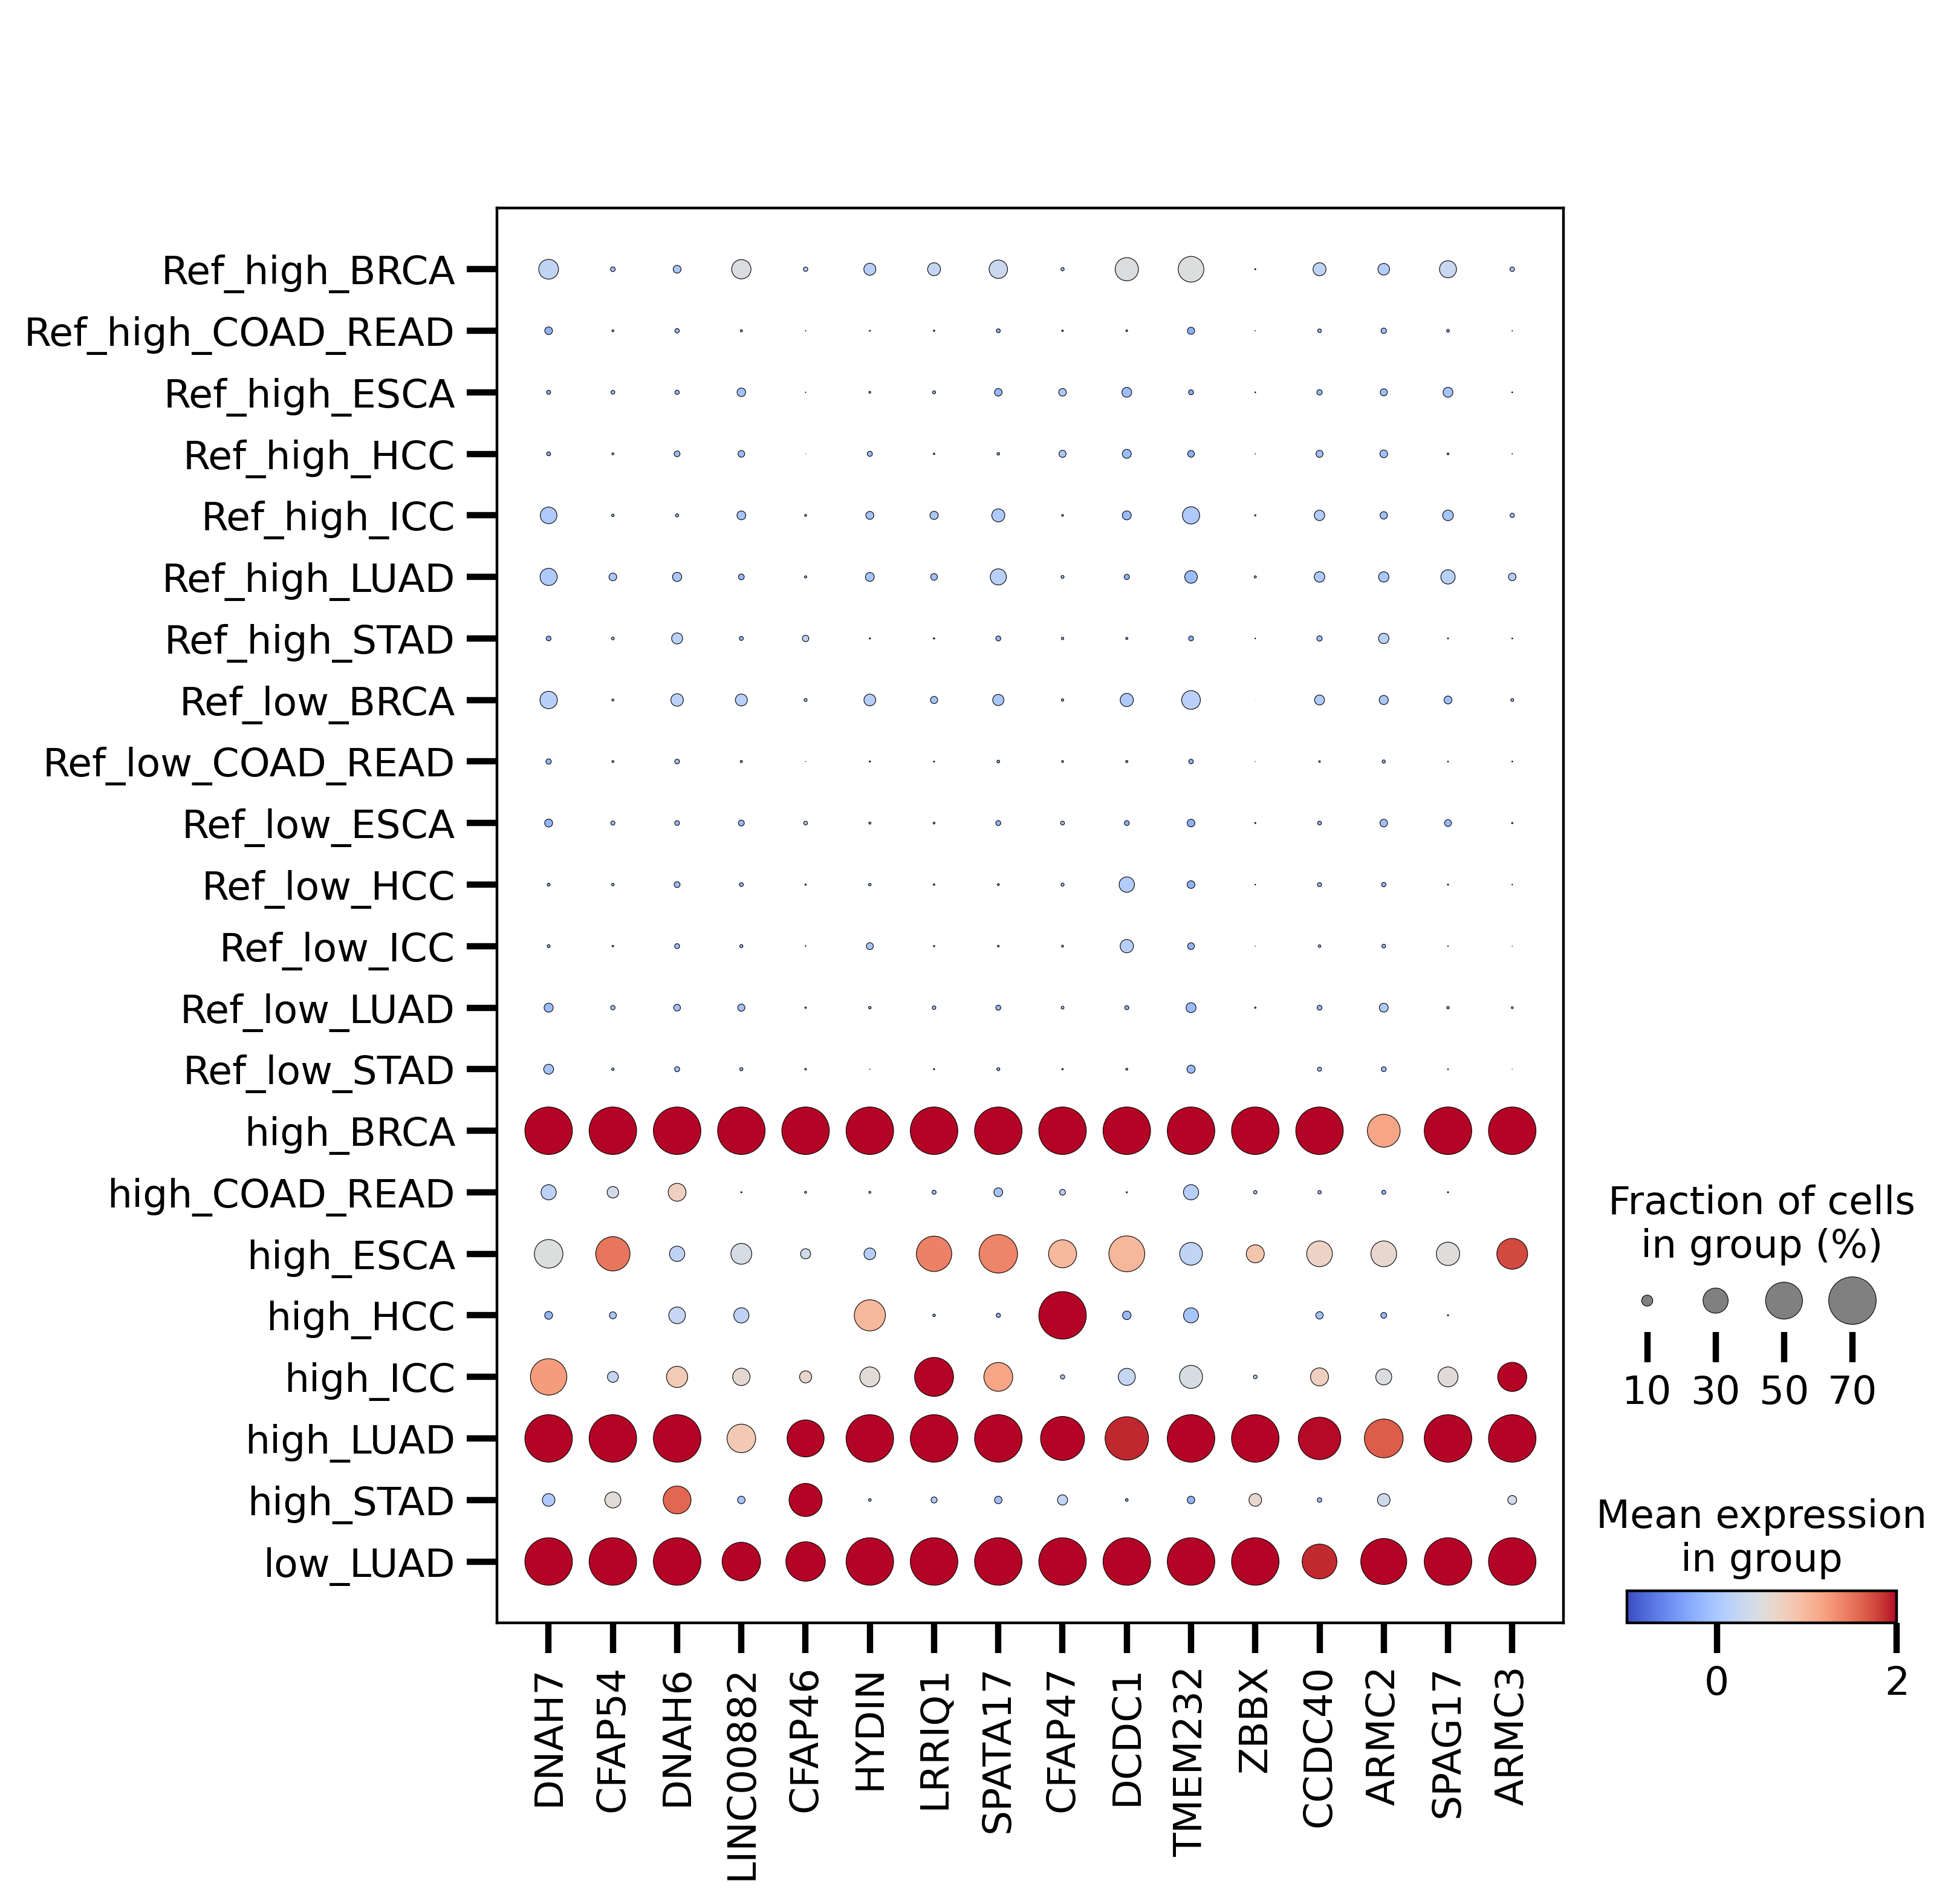

In [101]:
#sc.pl.dotplot(adata, list(set(high_gene_list).intersection(set(low_gene_list))), 
sc.pl.dotplot(adata, gene_list_used, 
              groupby='cnv_patient', use_raw=False, 
              vmin=-1, vmax=2, cmap='coolwarm', dot_max=0.7, save='DEG_inter.pdf')